In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [6]:
#set up file input
from google.colab import files
import io
uploaded = files.upload()
updf = pd.read_csv(io.BytesIO(uploaded['intenttrain.csv']), header = "infer", index_col = False, encoding= 'cp1252')

Saving intenttrain.csv to intenttrain.csv


In [7]:
#format for tensorflow text dataset
import os

if not os.path.exists(os.getcwd() + "/data"):
  alldata = os.getcwd() + "/data"
  os.mkdir(alldata)
if not os.path.exists(os.getcwd() + "/data/define"):
  ddir = os.getcwd() + "/data/define"
  os.mkdir(ddir)
if not os.path.exists(os.getcwd() + "/data/explore"):
  edir = os.getcwd() + "/data/explore"
  os.mkdir(edir)
if not os.path.exists(os.getcwd() + "/data/modify"):
  mdir = os.getcwd() + "/data/modify"
  os.mkdir(mdir)

for incr, row in updf.iterrows():
  if row[1] == 'd':
    with open(ddir + '/d' + str(incr) + '.txt', "w", encoding = 'utf8') as out:
      out.write(str(row['questions']))
      out.close()
  elif row[1] == 'e':
    with open(edir + '/e' + str(incr) + '.txt', "w", encoding = 'utf8') as out:
      out.write(str(row['questions']))
      out.close()
  elif row[1] == 'm':
    with open(mdir + '/m' + str(incr) + '.txt', "w", encoding = 'utf8') as out:
      out.write(str(row['questions']))
      out.close()

batch_sz = 10

trainds = keras.utils.text_dataset_from_directory(alldata, labels='inferred', 
                                                  label_mode='categorical', batch_size = batch_sz,
                                                  validation_split = 0.2, subset = 'training',
                                                  seed = 170230
                                                  )
valds = keras.utils.text_dataset_from_directory(alldata, labels='inferred', 
                                                  label_mode='categorical', batch_size = batch_sz,
                                                  validation_split = 0.2, subset = 'validation',
                                                  seed = 170230
                                                  )







Found 239 files belonging to 3 classes.
Using 192 files for training.
Found 239 files belonging to 3 classes.
Using 47 files for validation.


In [8]:
VOCAB_SIZE = 700

encoder = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(trainds.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

vocab[-30:]

array(['before', 'beer', 'bbq', 'baste', 'basically', 'banana', 'baking',
       'bake', 'bainmarie', 'bad', 'avoid', 'authentic', 'au', 'asked',
       'ask', 'asap', 'apricot', 'apples', 'apple', 'andor', 'amount',
       'american', 'alternatives', 'allergic', 'airfryer', 'afraid',
       'able', '4', '2', '1'], dtype='<U15')

In [9]:
# Define a function to extract the data from a tensorflow dataset so that we can work with Pandas Dataframes/Series objects
# when using Sklearn Naive Bayes

def get_tf_data(data):
  dat = []

  for feature_batch, label_batch in data.take(-1):
    print(feature_batch, label_batch)
    for features, label in zip(feature_batch.numpy(), label_batch.numpy()):
      dat.append((features, pd.Series(label, index = ['d', 'e', 'm']).idxmax()))

  return dat

train_df = pd.DataFrame(get_tf_data(trainds), columns = ['questions', 'label'])
test_df = pd.DataFrame(get_tf_data(valds), columns = ['questions', 'label'])

tf.Tensor(
[b'Say I want to make pecan pie but I have no corn syrup. What do I do?'
 b'what do you mean by'
 b'Can you replace that third ingredient with anything?'
 b"I need to know how to make sushi asap because I am spending half my monthly budget on sushi I can't sustain this please help I'm broke but if I don't keep eating sushi I'll be so hungry its the only thing I can eat help me please you're my only hope"
 b"I don't understand how to do that thing in step 4"
 b'I want to surprise my friend for his birthday by making him his favorite pie: lemon meringue. The only problem is that I have no idea how to make meringue.'
 b'How could I get out of using any meat in this recipe?'
 b'can you find me a recipe using pork'
 b'can you find me a recipe using eggs and mustard'
 b'How could I not use tajin in this?'], shape=(10,), dtype=string) tf.Tensor(
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(10, 3), d

In [10]:
catplotdata = pd.concat([train_df, test_df])
catplotdata.head(20)


,questions,label
0,b'Say I want to make pecan pie but I have no c...,m
1,b'what do you mean by',d
2,b'Can you replace that third ingredient with a...,m
3,"b""I need to know how to make sushi asap becaus...",e
4,"b""I don't understand how to do that thing in s...",d
5,b'I want to surprise my friend for his birthda...,e
6,b'How could I get out of using any meat in thi...,m
7,b'can you find me a recipe using pork',e
8,b'can you find me a recipe using eggs and must...,e
9,b'How could I not use tajin in this?',m


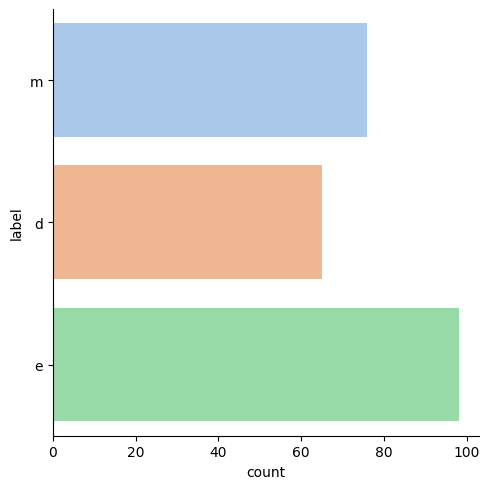

In [11]:
sns.catplot(data = catplotdata, x=None, y="label", kind="count", palette="pastel")

#Naive Bayes

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB

X_train = train_df['questions']
y_train = train_df['label']

X_test = test_df['questions']
y_test = test_df['label']

## Pipeline and GridSearchCV for Optimal Naive Bayes Variant and Hyperparameters

In [13]:
from sklearn.utils.metaestimators import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a generic class for usage with Sklearn estimators so that we can 
# test multiple models (MultinomialNB and BernoulliNB) using the same pipeline
class naive_bayes_mod(BaseEstimator):
  def __init__(self, estimator = MultinomialNB()):
    self.estimator = estimator

  def fit(self, X, y = None, **kwargs):
    self.estimator.fit(X, y)
    return self

  def predict(self, X, y = None):
    return self.estimator.predict(X)

  def score(self, X, y):
    return self.estimator.score(X, y)

pipe = Pipeline(steps = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('nb', naive_bayes_mod())
])

params = [{ 
    # First dictionary is for multinomial naive bayes
    'count_vectorizer__stop_words': ['english', None],           # English stop words set has many known problems, so try the vectorization 
                                                                 # without using stop words at all
           
    'tfidf_transformer': [TfidfTransformer(), 'passthrough'],    # Whether to use count vectorized (skipping the TfidfTransformer step) 
                                                                 # or tfidf vectorized
    'nb__estimator': [MultinomialNB()],
    'nb__estimator__alpha': [0.001, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9, 1],
    #'nb__estimator__class_prior': [(0.25, 0.75), (0.5, 0.5), (0.75, 0.25)]
}, {
    # Second dictionary is for bernoulli naive bayes
    'count_vectorizer__stop_words': ['english', None],   
    'count_vectorizer__binary' : [True],                         # Only use binary word occurrence for bernoulli
    'tfidf_transformer': ['passthrough'],                        # Skip the TfidfTransformer step
    'nb__estimator': [BernoulliNB()],
    'nb__estimator__alpha': [0.001, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9, 1],
    'nb__estimator__fit_prior' : [True, False]
    #'nb__estimator__class_prior': [(0.25, 0.75), (0.5, 0.5), (0.75, 0.25)]
}, {
    # Second dictionary is for bernoulli naive bayes
    'count_vectorizer__stop_words': ['english', None],   
    'count_vectorizer__binary' : [True],                         # Only use binary word occurrence for bernoulli
    'tfidf_transformer': ['passthrough'],                        # Skip the TfidfTransformer step
    'nb__estimator': [ComplementNB()],
    'nb__estimator__alpha': [0.001, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9, 1],
}]

grid_nb = GridSearchCV(pipe, params, cv = 10, scoring = 'accuracy').fit(X_train, y_train)

In [14]:
grid_nb.best_params_

{'count_vectorizer__binary': True,
 'count_vectorizer__stop_words': None,
 'nb__estimator': ComplementNB(alpha=0.66),
 'nb__estimator__alpha': 0.66,
 'tfidf_transformer': 'passthrough'}

In [15]:
# best_estimator_ returns the entire pipeline, so we can use the predict method directly on un-vectorized test data
best_nb = grid_nb.best_estimator_

In [16]:
#recover optimal parameters from the model
best_nb.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('count_vectorizer', CountVectorizer(binary=True)),
                ('tfidf_transformer', 'passthrough'),
                ('nb', naive_bayes_mod(estimator=ComplementNB(alpha=0.66)))])>

## Prediction on Test Data

              precision    recall  f1-score   support

      define       0.92      0.86      0.89        14
     explore       0.80      0.89      0.84        18
      modify       0.93      0.87      0.90        15

    accuracy                           0.87        47
   macro avg       0.88      0.87      0.88        47
weighted avg       0.88      0.87      0.87        47



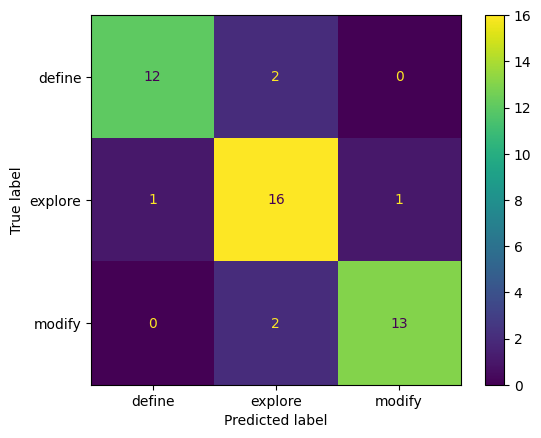

In [17]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

mappings = {'d' : 'define', 'e' : 'explore', 'm' : 'modify'}

# Predict on the test data and print evaluation metrics
preds = best_nb.predict(X_test)
print(classification_report(y_test, preds, target_names = mappings.values()))
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels = mappings.values())

In [18]:
misclassification_count = 0
correct_disp = 0
i = 0
print("INCORRECT PREDICTIONS:")
while misclassification_count < 10:
  try:
    if (preds[i] != y_test[i]):
      print('\t"' + str(X_test[i])[2:] + '"')     # [2:-3] to cut off unwanted starting and ending characters
      print('\tActual Sentiment: {}\t\tPredicted Sentiment: {}\n'.format(mappings.get(y_test[i]), mappings.get(preds[i])))
      misclassification_count += 1
  except:
    print("less than 10")
    break
  i += 1

print("CORRECT PREDICTIONS:")
i = 0
while correct_disp < 10:
  if (preds[i] == y_test[i]):
    print('\t"' + str(X_test[i])[2:] + '"')     # [2:-3] to cut off unwanted starting and ending characters
    print('\tActual Sentiment: {}\t\tPredicted Sentiment: {}\n'.format(mappings.get(y_test[i]), mappings.get(preds[i])))
    correct_disp += 1

  i += 1

INCORRECT PREDICTIONS:
	"How can I make this recipe without using dairy products?'"
	Actual Sentiment: modify		Predicted Sentiment: explore

	"Am I supposed to marinate chicken before I grill it?'"
	Actual Sentiment: explore		Predicted Sentiment: define

	"I've been tasked with bringing the hors doeuvres for this fancy party I'm going to but the only proper dish I'm familiar with that fits that description are deviled eggs. Unfortunately, the host is vegan so those are a no go (even though I think they're delicious). Do you have anything that could work for my situation?""
	Actual Sentiment: explore		Predicted Sentiment: modify

	"what would you do if you didn\xe2\x80\x99t want to turn on the oven?'"
	Actual Sentiment: modify		Predicted Sentiment: explore

	"how do I blanch broccolli?'"
	Actual Sentiment: define		Predicted Sentiment: explore

	"how do you zest a lime?'"
	Actual Sentiment: define		Predicted Sentiment: explore

less than 10
CORRECT PREDICTIONS:
	"how do I make red beans 

#Logistic Regressor GridSearchCV for Optimal Hyperparameters



In [ ]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(steps = [
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('linreg', LogisticRegression())
])

params = [{ 
    'count_vectorizer__stop_words': ['english', None],           # English stop words set has many known problems, so try the vectorization 
                                                                 # without using stop words at all
           
    'tfidf_transformer': [TfidfTransformer(), 'passthrough'],    # Whether to use count vectorized (skipping the TfidfTransformer step) 
                                                                 # or tfidf vectorized
    'linreg__penalty': ['l1', 'l2', 'elasticnet', None],                 
    'linreg__tol' : [1e-3, 1e-4, 1e-5, 1e-6, 0],
    'linreg__C' : [0.1, 1, 10, 100, 1000],
    'linreg__class_weight' : ['balanced', None],
    'linreg__random_state' : [12],
    'linreg__solver' : ['liblinear', 'lbfgs', 'newton-cg', 'newton_cholesky', 'sag', 'saga'],
    'linreg__max_iter' : [250]
}]

grid_logr = GridSearchCV(pipe, params, cv = 10, scoring = 'accuracy').fit(X_train, y_train)

In [20]:
# best_estimator_ returns the entire pipeline, so we can use the predict method directly on un-vectorized test data
best_linreg = grid_logr.best_estimator_

In [21]:
#recover optimal parameters from the model
best_linreg.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', TfidfTransformer()),
                ('linreg',
                 LogisticRegression(C=10, max_iter=250, penalty='l1',
                                    random_state=12, solver='saga'))])>

In [22]:
best_linreg

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', TfidfTransformer()),
                ('linreg',
                 LogisticRegression(C=10, max_iter=250, penalty='l1',
                                    random_state=12, solver='saga'))])

              precision    recall  f1-score   support

      define       0.86      0.86      0.86        14
     explore       0.88      0.83      0.86        18
      modify       0.81      0.87      0.84        15

    accuracy                           0.85        47
   macro avg       0.85      0.85      0.85        47
weighted avg       0.85      0.85      0.85        47



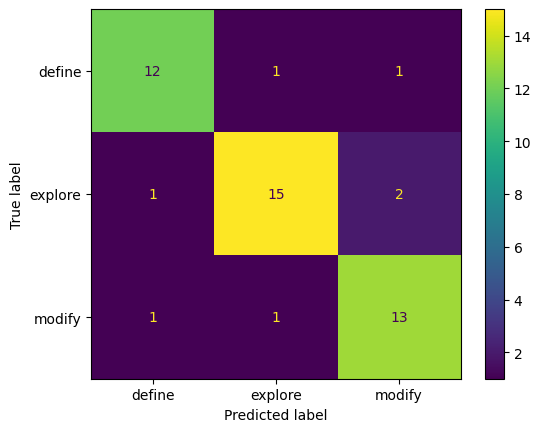

In [23]:
# Predict on the test data and print evaluation metrics
preds = best_linreg.predict(X_test)
print(classification_report(y_test, preds, target_names = mappings.values()))
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels = mappings.values())

In [24]:
misclassification_count = 0
correct_disp = 0
i = 0
print("INCORRECT PREDICTIONS:")
while misclassification_count < 10:
  try:
    if (preds[i] != y_test[i]):
      print('\t"' + str(X_test[i])[2:] + '"')     # [2:-3] to cut off unwanted starting and ending characters
      print('\tActual Sentiment: {}\t\tPredicted Sentiment: {}\n'.format(mappings.get(y_test[i]), mappings.get(preds[i])))
      misclassification_count += 1
  except:
    print("less than 10")
    break
  i += 1

print("CORRECT PREDICTIONS:")
i = 0
while correct_disp < 10:
  if (preds[i] == y_test[i]):
    print('\t"' + str(X_test[i])[2:] + '"')     # [2:-3] to cut off unwanted starting and ending characters
    print('\tActual Sentiment: {}\t\tPredicted Sentiment: {}\n'.format(mappings.get(y_test[i]), mappings.get(preds[i])))
    correct_disp += 1

  i += 1

INCORRECT PREDICTIONS:
	"Am I supposed to marinate chicken before I grill it?'"
	Actual Sentiment: explore		Predicted Sentiment: define

	"I've been tasked with bringing the hors doeuvres for this fancy party I'm going to but the only proper dish I'm familiar with that fits that description are deviled eggs. Unfortunately, the host is vegan so those are a no go (even though I think they're delicious). Do you have anything that could work for my situation?""
	Actual Sentiment: explore		Predicted Sentiment: modify

	"Can you clarify the difference between baking powder and baking soda in a recipe?'"
	Actual Sentiment: define		Predicted Sentiment: explore

	"can you explain to me'"
	Actual Sentiment: define		Predicted Sentiment: modify

	"Can I airfry sweet potatoes?'"
	Actual Sentiment: explore		Predicted Sentiment: modify

	"what would you do if you didn\xe2\x80\x99t want to turn on the oven?'"
	Actual Sentiment: modify		Predicted Sentiment: define

	"I don't have any manchego cheese on

In [25]:
import pickle

rmodelout = "intent_regressor.model"
nbmodelout = "intent_bayes.model"
pickle.dump(best_linreg, open(rmodelout, 'wb'))
pickle.dump(best_nb, open(nbmodelout, 'wb'))